In [3]:
#기본
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import FinanceDataReader as fdr
import mglearn
import sklearn

#분류 모델
from sklearn.svm import LinearSVC
from sklearn import neighbors,svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#스케일러
from sklearn.preprocessing import MinMaxScaler

#성과 평가
from sklearn.metrics import confusion_matrix #오차행렬
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_10=df["Close"].rolling(10).mean()
    MA_60=df["Close"].rolling(60).mean
    df=df.assign(MA_10=MA_10,MA_60=MA_60).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df

In [5]:
# Methods

#train_test_split, score 도출----------------------

def print_score(X,y,model):
    
    setlen=int(round(len(X)*0.7,0))
    y=y.astype('int')
    X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

    reg=model.fit(X_train,y_train)
    print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
    print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

    confusion=confusion_matrix(y_test,reg.predict(X_test))
    print(confusion)
    
    


#미래 예측을 위한 시간조정-------------------   

def adjust_time(X,y):
    y=pd.DataFrame(np.array(y),index=X.index).shift(-1).dropna()
    X=X.loc[y.index].dropna()
    
    return X,y


In [6]:

RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:


KS=fdr.DataReader("HSI","1990-01-01","2019-08-14")

#특성 추가---
KS=get_stochastic(KS)
KS=get_time(KS)

X=KS
#--------
MA_60=KS["Close"].rolling(60).mean()
MA_90=KS["Close"].rolling(90).mean()
MA_120=KS["Close"].rolling(120).mean()
MA_180=KS["Close"].rolling(180).mean()
MA_360=KS["Close"].rolling(360).mean()
malist=[MA_60,MA_90,MA_120,MA_180,MA_360]
KS_MA=KS.assign(MA_60=MA_60,MA_90=MA_90,MA_120=MA_120,MA_180=MA_180,MA_360=MA_360).dropna()


HSI


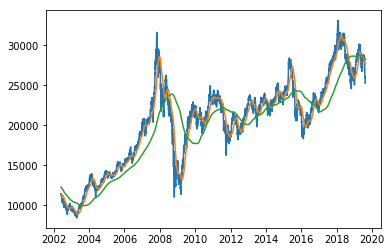

In [8]:


plt.plot(KS_MA.index,KS_MA["Close"])
plt.plot(KS_MA.index,KS_MA["MA_60"])
plt.plot(KS_MA.index,KS_MA["MA_360"])
print("HSI")

MA_60


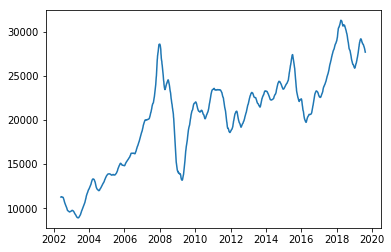

In [9]:
plt.plot(KS_MA.index,KS_MA["MA_60"])
print("MA_60")

MA_360


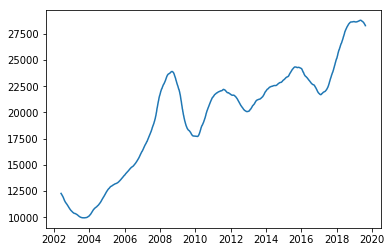

In [10]:
plt.plot(KS_MA.index,KS_MA["MA_360"])
print("MA_360")

In [11]:
def cross_score(X,y,SC):
    print("\n교차검증 테스트------")
    len1=int(round(len(X)*1/5,0))
    len2=int(round(len1*4/5,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score1=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score1=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*2/5,0))
    len2=int(round(len1*9/10,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score2=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score2=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*3/5,0))
    len2=int(round(len1*14/15,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score3=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score3=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*4/5,0))
    len2=int(round(len1*19/20,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score4=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score4=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    len1=int(round(len(X)*5/5,0))
    len2=int(round(len1*24/25,0))
    X_cross,y_cross=X[:len1],y[:len1]
    X_train,y_train,X_test,y_test=X_cross[:len2],y_cross[:len2],X_cross[len2:],y_cross[len2:]
    train_score5=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_train,y_train)
    test_score5=RandomForestClassifier(random_state=2).fit(X_train,y_train).score(X_test,y_test)

    X_train_score=(train_score1+train_score2+train_score3+train_score4+train_score5)/5
    X_test_score=(test_score1+test_score2+test_score3+test_score4+test_score5)/5
    print("교차검증 훈련 점수 : ",X_train_score,"\n교차검증 테스트 점수 : ",X_test_score)
    SC.append("훈련 교차 :%s, 테스트 교차 : %s" %(X_train_score,X_test_score))


In [12]:
KS

,Close,Open,High,Low,Volume,Change,kdj_k,kdj_d,kdj_j,time
Date,,,,,,,,,,
2000-12-05,14573.21,14602.25,14701.98,14507.50,0.000000e+00,0.0010,33.787536,33.787536,33.787536,0.000000
2000-12-06,15098.95,14914.54,15178.27,14914.54,0.000000e+00,0.0361,88.174784,66.419885,55.542435,0.002159
2000-12-07,15011.52,14982.92,15032.27,14839.38,0.000000e+00,-0.0058,75.140510,70.550707,64.118591,0.004318
2000-12-08,15189.33,15008.80,15281.81,14968.64,0.000000e+00,0.0118,88.056463,77.822329,71.427251,0.006477
2000-12-11,15408.54,15274.07,15438.89,15193.49,0.000000e+00,0.0144,96.741429,85.085112,78.476469,0.008636
2000-12-12,15329.60,15498.45,15548.26,15319.84,0.000000e+00,-0.0051,78.990353,82.858004,80.702011,0.010794
2000-12-13,15621.73,14986.08,15637.78,14986.08,0.000000e+00,0.0191,98.579998,88.424461,84.593639,0.012953
2000-12-14,15496.99,15543.85,15597.63,15441.58,0.000000e+00,-0.0080,87.543794,88.118986,86.363225,0.015112
2000-12-15,14975.53,15290.60,15290.60,14914.05,0.000000e+00,-0.0336,41.408324,72.132931,79.234154,0.017271


In [13]:




SC=[]
for y in ["US500","RSTI","EURO","HSI"]:
    SC.append(y)
    print("\n",y,"-------------")
    
    KS=fdr.DataReader(y,"1990-01-01","2019-10-01")
    KS=get_stochastic(KS)
    KS=get_time(KS)
    
    
    MA_60=KS["Close"].rolling(60).mean().dropna()
    MA_90=KS["Close"].rolling(90).mean().dropna()
    MA_120=KS["Close"].rolling(120).mean().dropna()
    MA_180=KS["Close"].rolling(180).mean().dropna()
    MA_360=KS["Close"].rolling(360).mean().dropna()
    malist=[MA_60,MA_90,MA_120,MA_180,MA_360]
    malist2=["MA_60","MA_90","MA_120","MA_180","MA_360",]
    n=0
    score_list=[]
        
    for x in malist:
        KS[malist2[n]]=x
        KS=KS.dropna()
        
        y=np.where(KS["Close"]>x,1,0)
        X,y=adjust_time(KS,y)

        setlen=int(round(len(X)*0.7,0))
        y=y.astype('int')
        X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]
        print(malist2[n])
        
        print_score(X,y,RandomForestClassifier(random_state=2))
        SC.append(malist2[n])
        cross_score(X,y,SC)
        n=n+1


 US500 -------------
MA_60
훈련 세트 정확도:0.997
테스트 세트 정확도:0.666
[[249  29]
 [311 430]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.8161764705882353 ,
 score 2 : 0.6875 ,
 score 3 : 0.8602941176470589 ,
 score 4 : 0.7132352941176471 ,
 score 5 : 0.8 ,

교차검증 훈련 점수 :  0.9941757689201335 
교차검증 테스트 점수 :  0.7754411764705884
MA_90
훈련 세트 정확도:0.997
테스트 세트 정확도:0.579
[[179  44]
 [381 406]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 1.0 ,
 score 2 : 0.6282527881040892 ,
 score 3 : 0.8910891089108911 ,
 score 4 : 0.7606679035250464 ,
 score 5 : 0.814540059347181 ,

교차검증 훈련 점수 :  0.9953858157642946 
교차검증 테스트 점수 :  0.8189099719774415
MA_120
훈련 세트 정확도:0.997
테스트 세트 정확도:0.216
[[195   3]
 [782  21]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 1.0 ,
 score 2 : 0.7265917602996255 ,
 score 3 : 0.9650872817955112 ,
 score 4 : 0.7883895131086143 ,
 score 5 : 0.8248502994011976 ,

교차검증 훈련 점수 :  0.9951747815230961 
교차검증 테스트 점수 :  0.8609837709209897
MA_180
훈련 세트 정확도:0.999
테스트 세트 정확도:0.234
[[110  42]
 [711 120]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

  score 1 : 1.0 ,
 score 2 : 0.33969465648854963 ,
 score 3 : 0.2900763358778626 ,
 score 4 : 0.7958015267175572 ,
 score 5 : 0.8734756097560976 ,

교차검증 훈련 점수 :  0.9981829173439424 
교차검증 테스트 점수 :  0.6598096257680134
MA_360
훈련 세트 정확도:1.000
테스트 세트 정확도:0.925
[[ 50  39]
 [ 31 809]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), f

  score 1 : 0.5645161290322581 ,
 score 2 : 0.75 ,
 score 3 : 1.0 ,
 score 4 : 0.7903225806451613 ,
 score 5 : 0.9274193548387096 ,

교차검증 훈련 점수 :  0.9988905526990894 
교차검증 테스트 점수 :  0.8064516129032258

 RSTI -------------
MA_60
훈련 세트 정확도:0.994
테스트 세트 정확도:0.770
[[256 102]
 [ 81 357]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.44339622641509435 ,
 score 2 : 0.6509433962264151 ,
 score 3 : 0.5817610062893082 ,
 score 4 : 0.6886792452830188 ,
 score 5 : 0.7740112994350282 ,

교차검증 훈련 점수 :  0.9946688331719564 
교차검증 테스트 점수 :  0.6277582347297729
MA_90
훈련 세트 정확도:0.996
테스트 세트 정확도:0.714
[[331  63]
 [162 231]]

교차검증 테스트------


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 

  score 1 : 0.5619047619047619 ,
 score 2 : 0.6523809523809524 ,
 score 3 : 0.5301587301587302 ,
 score 4 : 0.44047619047619047 ,
 score 5 : 0.7714285714285715 ,

교차검증 훈련 점수 :  0.9975614181437757 
교차검증 테스트 점수 :  0.5912698412698413
MA_120
훈련 세트 정확도:0.997
테스트 세트 정확도:0.667
[[322  66]
 [193 197]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.5384615384615384 ,
 score 2 : 0.5072463768115942 ,
 score 3 : 0.5627009646302251 ,
 score 4 : 0.41686746987951806 ,
 score 5 : 0.6917148362235067 ,

교차검증 훈련 점수 :  0.9977905691762151 
교차검증 테스트 점수 :  0.5433982372012764
MA_180
훈련 세트 정확도:0.999
테스트 세트 정확도:0.566
[[130 256]
 [ 74 300]]

교차검증 테스트------


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 

  score 1 : 0.7029702970297029 ,
 score 2 : 0.4876847290640394 ,
 score 3 : 0.680921052631579 ,
 score 4 : 0.4888888888888889 ,
 score 5 : 0.5069033530571992 ,

교차검증 훈련 점수 :  0.9977644920664324 
교차검증 테스트 점수 :  0.5734736641342819
MA_360
훈련 세트 정확도:0.997
테스트 세트 정확도:0.279
[[  8 346]
 [163 189]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 1.0 ,
 score 2 : 1.0 ,
 score 3 : 0.9326241134751773 ,
 score 4 : 0.22340425531914893 ,
 score 5 : 0.5138004246284501 ,

교차검증 훈련 점수 :  0.9983530278461077 
교차검증 테스트 점수 :  0.7339657586845553

 EURO -------------
MA_60
훈련 세트 정확도:0.988
테스트 세트 정확도:0.742
[[247  92]
 [ 12  52]]

교차검증 테스트------
  score 1 : 0.6666666666666666 ,
 score 2 : 0.6666666666666666 ,
 score 3 : 0.7267080745341615 ,
 score 4 : 0.6558139534883721 ,
 score 5 : 0.8587360594795539 ,

교차검증 훈련 점수 :  0.9874418604651163 
교차검증 테스트 점수 :  0.7149182841670841


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

MA_90
훈련 세트 정확도:0.991
테스트 세트 정확도:0.749
[[269  86]
 [ 13  26]]

교차검증 테스트------
  score 1 : 0.2641509433962264 ,
 score 2 : 0.4380952380952381 ,
 score 3 : 0.47468354430379744 ,
 score 4 : 0.24285714285714285 ,
 score 5 : 0.9277566539923955 ,

교차검증 훈련 점수 :  0.9949081935388392 
교차검증 테스트 점수 :  0.46950870452896004


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

MA_120
훈련 세트 정확도:0.997
테스트 세트 정확도:0.397
[[141 229]
 [  3  12]]

교차검증 테스트------
  score 1 : 0.0784313725490196 ,
 score 2 : 0.8252427184466019 ,
 score 3 : 0.6753246753246753 ,
 score 4 : 0.14146341463414633 ,
 score 5 : 0.41245136186770426 ,

교차검증 훈련 점수 :  0.9971446267551783 
교차검증 테스트 점수 :  0.4265827085644295


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

MA_180
훈련 세트 정확도:0.996
테스트 세트 정확도:0.602
[[219 146]
 [  0   2]]

교차검증 테스트------
  score 1 : 0.16326530612244897 ,
 score 2 : 0.6836734693877551 ,
 score 3 : 0.7891156462585034 ,
 score 4 : 0.1683673469387755 ,
 score 5 : 0.4897959183673469 ,

교차검증 훈련 점수 :  0.9979070036273778 
교차검증 테스트 점수 :  0.4588435374149659


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

MA_360
훈련 세트 정확도:0.993
테스트 세트 정확도:0.460
[[143 165]
 [  4   1]]

교차검증 테스트------
  score 1 : 0.9761904761904762 ,
 score 2 : 0.7261904761904762 ,
 score 3 : 1.0 ,
 score 4 : 0.7065868263473054 ,
 score 5 : 0.8995215311004785 ,

교차검증 훈련 점수 :  0.9954491017964072 
교차검증 테스트 점수 :  0.8616978619657474

 HSI -------------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

MA_60
훈련 세트 정확도:0.996
테스트 세트 정확도:0.766
[[512  78]
 [245 546]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.6141304347826086 ,
 score 2 : 0.7228260869565217 ,
 score 3 : 0.7197106690777577 ,
 score 4 : 0.6472184531886025 ,
 score 5 : 0.7328990228013029 ,

교차검증 훈련 점수 :  0.9966479801422855 
교차검증 테스트 점수 :  0.6873569333613586
MA_90
훈련 세트 정확도:0.996
테스트 세트 정확도:0.696
[[424 205]
 [212 532]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.6502732240437158 ,
 score 2 : 0.6994535519125683 ,
 score 3 : 0.6265938069216758 ,
 score 4 : 0.7158469945355191 ,
 score 5 : 0.5038251366120219 ,

교차검증 훈련 점수 :  0.9971311475409836 
교차검증 테스트 점수 :  0.6391985428051002
MA_120
훈련 세트 정확도:0.996
테스트 세트 정확도:0.665
[[512  52]
 [404 395]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,)

  score 1 : 0.43956043956043955 ,
 score 2 : 0.6483516483516484 ,
 score 3 : 0.581651376146789 ,
 score 4 : 0.7510316368638239 ,
 score 5 : 0.4675467546754675 ,

교차검증 훈련 점수 :  0.9960761186710727 
교차검증 테스트 점수 :  0.5776283711196337
MA_180
훈련 세트 정확도:0.997
테스트 세트 정확도:0.700
[[392 110]
 [294 549]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 0.9217877094972067 ,
 score 2 : 0.4623955431754875 ,
 score 3 : 0.5762081784386617 ,
 score 4 : 0.6713091922005571 ,
 score 5 : 0.7357859531772575 ,

교차검증 훈련 점수 :  0.9985787182099963 
교차검증 테스트 점수 :  0.6734973152978341
MA_360
훈련 세트 정확도:0.999
테스트 세트 정확도:0.786
[[377 109]
 [167 638]]

교차검증 테스트------


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was 

  score 1 : 1.0 ,
 score 2 : 0.33430232558139533 ,
 score 3 : 0.44294003868471954 ,
 score 4 : 0.690856313497823 ,
 score 5 : 0.7363530778164924 ,

교차검증 훈련 점수 :  0.9994386501074215 
교차검증 테스트 점수 :  0.6408903511160859


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), f

In [14]:
SC

['US500',
 'MA_60',
 '훈련 교차 :0.9941757689201335, 테스트 교차 : 0.7754411764705884',
 'MA_90',
 '훈련 교차 :0.9953858157642946, 테스트 교차 : 0.8189099719774415',
 'MA_120',
 '훈련 교차 :0.9951747815230961, 테스트 교차 : 0.8609837709209897',
 'MA_180',
 '훈련 교차 :0.9981829173439424, 테스트 교차 : 0.6598096257680134',
 'MA_360',
 '훈련 교차 :0.9988905526990894, 테스트 교차 : 0.8064516129032258',
 'RSTI',
 'MA_60',
 '훈련 교차 :0.9946688331719564, 테스트 교차 : 0.6277582347297729',
 'MA_90',
 '훈련 교차 :0.9975614181437757, 테스트 교차 : 0.5912698412698413',
 'MA_120',
 '훈련 교차 :0.9977905691762151, 테스트 교차 : 0.5433982372012764',
 'MA_180',
 '훈련 교차 :0.9977644920664324, 테스트 교차 : 0.5734736641342819',
 'MA_360',
 '훈련 교차 :0.9983530278461077, 테스트 교차 : 0.7339657586845553',
 'EURO',
 'MA_60',
 '훈련 교차 :0.9874418604651163, 테스트 교차 : 0.7149182841670841',
 'MA_90',
 '훈련 교차 :0.9949081935388392, 테스트 교차 : 0.46950870452896004',
 'MA_120',
 '훈련 교차 :0.9971446267551783, 테스트 교차 : 0.4265827085644295',
 'MA_180',
 '훈련 교차 :0.9979070036273778, 테스트 교차 : 0.4588435374149659

In [15]:
SC

['US500',
 'MA_60',
 '훈련 교차 :0.9941757689201335, 테스트 교차 : 0.7754411764705884',
 'MA_90',
 '훈련 교차 :0.9953858157642946, 테스트 교차 : 0.8189099719774415',
 'MA_120',
 '훈련 교차 :0.9951747815230961, 테스트 교차 : 0.8609837709209897',
 'MA_180',
 '훈련 교차 :0.9981829173439424, 테스트 교차 : 0.6598096257680134',
 'MA_360',
 '훈련 교차 :0.9988905526990894, 테스트 교차 : 0.8064516129032258',
 'RSTI',
 'MA_60',
 '훈련 교차 :0.9946688331719564, 테스트 교차 : 0.6277582347297729',
 'MA_90',
 '훈련 교차 :0.9975614181437757, 테스트 교차 : 0.5912698412698413',
 'MA_120',
 '훈련 교차 :0.9977905691762151, 테스트 교차 : 0.5433982372012764',
 'MA_180',
 '훈련 교차 :0.9977644920664324, 테스트 교차 : 0.5734736641342819',
 'MA_360',
 '훈련 교차 :0.9983530278461077, 테스트 교차 : 0.7339657586845553',
 'EURO',
 'MA_60',
 '훈련 교차 :0.9874418604651163, 테스트 교차 : 0.7149182841670841',
 'MA_90',
 '훈련 교차 :0.9949081935388392, 테스트 교차 : 0.46950870452896004',
 'MA_120',
 '훈련 교차 :0.9971446267551783, 테스트 교차 : 0.4265827085644295',
 'MA_180',
 '훈련 교차 :0.9979070036273778, 테스트 교차 : 0.4588435374149659

In [16]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

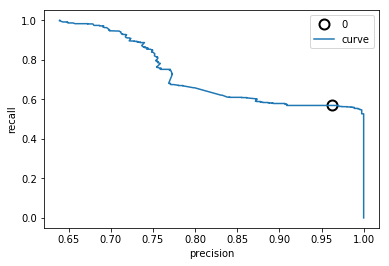

In [17]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='0',fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="curve")
plt.xlabel("precision")
plt.ylabel('recall')
plt.legend(loc="best")


NameError: name 'close_default_rf' is not defined

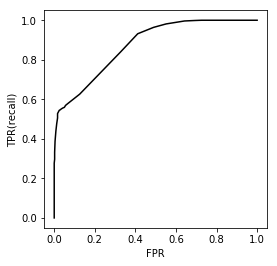

In [18]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(4, 4))
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_test,reg3.predict_proba(X_test)[:,1])

plt.plot(fpr_rf,tpr_rf,'k')
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.plot(fpr_rf[close_default_rf],tpr_rf[close_default_rf],'^',markersize=10,label="RF recall : 0.5",fillstyle="none",mew=2)


In [ ]:
X

In [ ]:
plt.plot(X.index,X["Close"])
plt.plot(X.index,X["MA_60"],'k')

In [ ]:
y

In [ ]:
plt.plot(X.index,X["Close"])

In [ ]:
plt.plot(X.index[:int(round(len(X.index)*0.8,0))],X["Close"][:int(round(len(X.index)*0.8,0))])
plt.plot(X.index[int(round(len(X.index)*0.8,0)):],X["Close"][int(round(len(X.index)*0.8,0)):])

plt.title("IXIC")

In [ ]:
X

In [ ]:
len(X)-setlen

In [ ]:
len(X_test)

In [ ]:
setlen=int(round(len(X)*0.7,0))

In [ ]:
len(X)-setlen

In [ ]:
time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)

In [ ]:

# 양수와 음수로 조정한 2중 분류 ---------------


y=np.where(KS["Close"]>KS["MA_60"],1,0)

X,y=adjust_time(KS,y)

setlen=int(round(len(X)*0.8,0))
y=y.astype('int')
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

print_score(X,y,RandomForestClassifier())


In [ ]:
lenset=np.linspace(0,100,5)
for x in lenset:
    len=int(len(X)*x)
    X_train,X_test,y_train,y_test=

In [ ]:
np.linspace(50,100,2)

In [ ]:
for i in np.linspace(50,100,2):
    df.loc[      KS [KS['Change'] >= initial]           [KS['Change'] <= round(np.percentile(KS['Change'], i),4)].index      ] = num
    initial = round(np.percentile(KS['Change'], i),4)
    num += 1

In [ ]:
np.percentile([0,1,2,3,4],)


In [ ]:
y=[60,90,120,180,360]
HIS=[0.7413,0.6994,0.6483,0.7452,0.65]
RSTI=[0.715,0.731,0.8297,0.7115,0.8702]
EURO=[0.7925,0.7509,0.7843,0.7346,0.8714]
SP=[0.8338,0.8859,0.8730,0.9572,0.8967]

In [ ]:
U=[0.7779411764705882,
0.68,
0.6692739310963978,
0.7709923664122138,
0.8435483870967742]

R=[0.660377358490566,
0.6266666666666667,
0.6788461538461539,
0.7683168316831683,
0.827659574468085]

E=[0.7444444444444445,
0.7660377358490567,
0.7411764705882352,
0.5428571428571429,
0.9428571428571428]

H=[0.6293478260869565,
0.6404371584699453,
0.543956043956044,
0.7027932960893855,
0.7662790697674418]

In [ ]:
plt.ylabel("accuracy")
plt.xlabel("MA")
plt.plot(y,U,label='US500')
plt.plot(y,R,label="RSTI")
plt.plot(y,E,label="EURO")
plt.plot(y,H,label="HSI")
plt.legend(loc=4)
plt.show()

In [ ]:
US500',
 'MA_60',
 '0.9946178808039561랑0.7779411764705882',
 'MA_90',
 '0.9954979693375515랑0.68',
 'MA_120',
 '0.9951081073342584랑0.6692739310963978',
 'MA_180',
 '0.9985671221637429랑0.7709923664122138',
 'MA_360',
 '0.9985205364519854랑0.8435483870967742',
 'RSTI',
 'MA_60',
 '0.9954822381817754랑0.660377358490566',
 'MA_90',
 '0.9965671430914064랑0.6266666666666667',
 'MA_120',
 '0.9979407023559823랑0.6788461538461539',
 'MA_180',
 '0.9972150610085759랑0.7683168316831683',
 'MA_360',
 '0.9983677397877042랑0.827659574468085',
 'EURO',
 'MA_60',
 '0.989258496068303랑0.7444444444444445',
 'MA_90',
 '0.9932027183301922랑0.7660377358490567',
 'MA_120',
 '0.9941954912887276랑0.7411764705882352',
 'MA_180',
 '0.9980217978301775랑0.5428571428571429',
 'MA_360',
 '0.9950377127333099랑0.9428571428571428',
 'HSI',
 'MA_60',
 '0.9961781187386279랑0.6293478260869565',
 'MA_90',
 '0.9968203751637746랑0.6404371584699453',
 'MA_120',
 '0.996045692447743랑0.543956043956044',
 'MA_180',
 '0.9981130899959823랑0.7027932960893855',
 'MA_360',
 '0.9993397619218852랑0.7662790697674418']